# Import Packages & Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../input/heart.csv")

# Data Quality & Missing Value Assessment

**Check missing values in data**

In [3]:
df.isnull().sum()

row.names    0
sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64

Since the data has no missing values, we proceed with data analysis.

# Exploratory Data Analysis

**Plot a pie chart showing % of people with and without CHD**

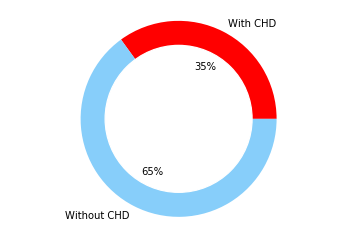

In [4]:
pie_slices = [round(((df['chd'] == 1).sum() / df.shape[0])*100), round(((df['chd'] == 0).sum() / df.shape[0])*100)]
plt.pie(pie_slices, labels = ['With CHD', 'Without CHD'], colors = ['red', 'lightskyblue'], autopct = '%1.0f%%')
        
# Draw a circle at the center of pie to make it look like a doughnut
ccircle = plt.Circle((0,0), 0.75, color='white', fc='white', linewidth=1.25)
plt.gcf().gca().add_artist(ccircle)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()  

**Plot a pie chart showing % of people with and without family history of CHD**

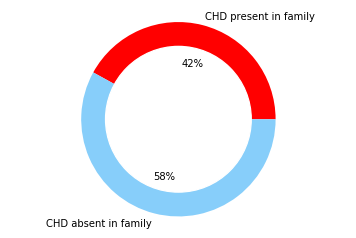

In [5]:
# Change present to 1 and absent to 0 in famhist column
df.loc[df.famhist == 'Present', 'famhist'] = 1
df.loc[df.famhist == 'Absent', 'famhist'] = 0

# Plot a pie chart
sizes = [round(((df['famhist'] == 1).sum() / df.shape[0])*100), round(((df['famhist'] == 0).sum() / df.shape[0])*100)]
plt.pie(sizes, labels  = ['CHD present in family', 'CHD absent in family'], colors  = ['red', 'lightskyblue'], autopct = '%1.0f%%')
        
# Draw a circle at the center of pie to make it look like a donut
ccircle = plt.Circle((0,0), 0.75, color='white', fc='white', linewidth=1.25)
plt.gcf().gca().add_artist(ccircle)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()  

**Show the number of people of different ages with CHD**

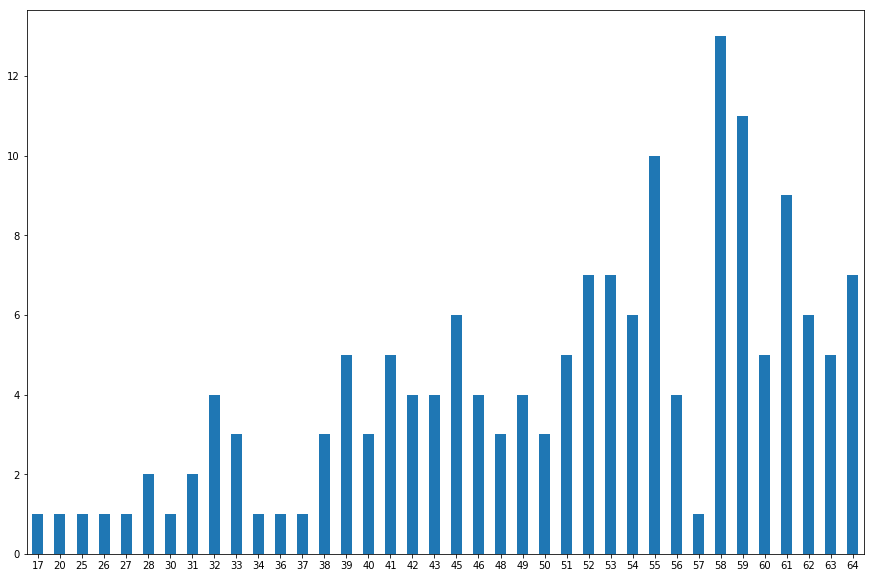

In [6]:
# Get the age of chd affected people
chd_age = df.loc[df['chd'] == 1, 'age']

# Get the count of different ages
age_count = chd_age.value_counts() 

# Create a bar plot
ax = age_count.sort_index().plot(kind = 'bar', figsize = (15,10), rot = 0)

# Logistic Regression

**Split data into train and test data**

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2)

**Build a logistic regression model on the training data**

In [8]:
from sklearn.linear_model import LogisticRegression
X = df[list(train.keys())[:-1:]]
y = df[list(train.keys())[-1]]

# Build a logistic regression and compute the feature importances
model = LogisticRegression(solver='liblinear')
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
from sklearn.feature_selection import RFE
rfe = RFE(model, 9)
rfe = rfe.fit(X, y)

# Summarize the selection of the attributes
# print (rfe.support_)
print('Selected features:', list(X.columns[rfe.support_]))

Selected features: ['row.names', 'sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity', 'age']


**Use Recursive Feature Elimination**

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and
the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from the current set of features. This procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Optimal number of features: 4
Selected features: ['tobacco', 'ldl', 'famhist', 'obesity']


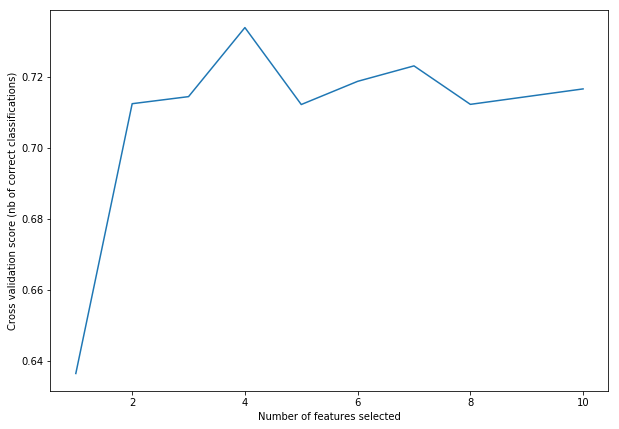

In [10]:
# RFECV - Feature ranking with recursive feature elimination 
# and cross-validated selection of the best number of features.
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=LogisticRegression(solver='liblinear'), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print('Optimal number of features:', rfecv.n_features_)
print('Selected features:', list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation score
plt.figure(figsize=(10,7))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

**Plot correlation matrix**

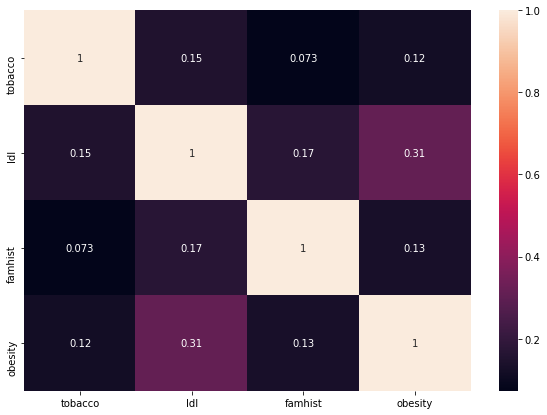

In [11]:
selected_features = list(X.columns[rfecv.support_])
X = train[selected_features]
plt.subplots(figsize=(10, 7))
sns.heatmap(X.corr(), annot=True)
plt.show()

**Run model on test data**

In [12]:
X_test = df[list(test.keys())[:-1:]]
y_test = df[list(test.keys())[-1]]
y_pred = model.predict(X_test)

In [13]:
# Get test accuracy score
from sklearn.metrics import accuracy_score
print('Test data accuracy:', round(accuracy_score(y_test,y_pred) * 100, 2),'%')

Test data accuracy: 73.16 %


**Plot confusion matrix**

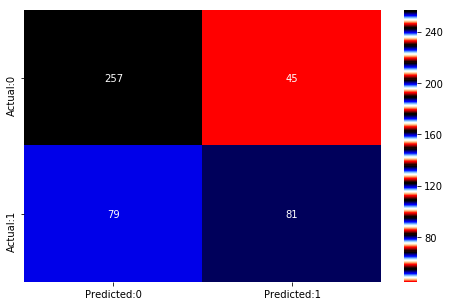

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])

plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='flag');


The confusion matrix shows 257 + 81 = 338 correct predictions and 79 + 45 = 124 incorrect ones.

* True Positives: 81
* True Negatives: 257
* False Positives: 45 
* False Negatives: 79



**Compute logistic regression evaluation metrics**

In [15]:
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

precision = TP / (TP + FP) 
recall = TP / (TP + FN)
f1score = 2 * precision * recall / (precision + recall)

print ('Precision = ', round(precision, 2))
print ('Recall = ', round(recall, 2))
print ('F1 score = ', round(f1score, 2))
print()

sensitivity = TP / float(TP + FN)
specificity = TN / float(TN + FP)

print('Correct predictions: ', TP + TN)
print('Accuracy of the model: ',             round((TP + TN) / float(TP + TN + FP + FN), 2))
print('Misclassification: ',                 round(1-((TP + TN) / float(TP + TN + FP + FN)), 2))
print('Sensitivity or True Positive Rate: ', round(TP / float(TP + FN), 2))
print('Specificity or True Negative Rate: ', round(TN / float(TN + FP), 2))
print('Positive predictive value: ',         round(TP / float(TP + FP), 2))
print('Negative predictive Value: ',         round(TN / float(TN + FN), 2))
print('Positive likelihood Ratio: ',         round(sensitivity / (1 - specificity), 2))
print('Negative likelihood Ratio: ',         round((1 - sensitivity) / specificity, 2))

Precision =  0.64
Recall =  0.51
F1 score =  0.57

Correct predictions:  338
Accuracy of the model:  0.73
Misclassification:  0.27
Sensitivity or True Positive Rate:  0.51
Specificity or True Negative Rate:  0.85
Positive predictive value:  0.64
Negative predictive Value:  0.76
Positive likelihood Ratio:  3.4
Negative likelihood Ratio:  0.58


In [16]:
# Compute the probability of the model predicting chd=0 (No Coronary Heart Disease) and chd=1 ( Coronary Heart Disease: Yes)
# on each test data with a default classification threshold of 0.5
y_pred_prob = model.predict_proba(X_test)[:,:]
y_pred_prob_df = pd.DataFrame(data = y_pred_prob, columns = ['P(chd = 0)', 'P(chd = 1)'])
y_pred_prob_df.head()

,P(chd = 0),P(chd = 1)
0,0.252259,0.747741
1,0.673756,0.326244
2,0.615428,0.384572
3,0.289686,0.710314
4,0.254747,0.745253


https://en.wikipedia.org/wiki/Sensitivity_and_specificity

Our model is more specific than sensitive i.e., it is **more likely** to correctly **identify** a patient **without** CHD than with CHD.

A higher false negatives count is not advisable as a false negative (ignoring the probability of disease when there actualy is one) is more dangerous than a false positive in this case. Hence, inorder to increase the sensitivity (true positive rate), threshold can be lowered.

**Compute confusion matrix for different threshold levels.**

In [17]:
from sklearn.preprocessing import binarize
for i in range(1,5):
    y_pred_prob_yes = model.predict_proba(X_test)
    y_pred2 = binarize(y_pred_prob_yes,i / 10)[:,1]
    cm2 = confusion_matrix(y_test, y_pred2)
    
    print('With', i/10, 'threshold, the confusion matrix is\n', cm2)
    print('with', cm2[0,0] + cm2[1,1], 'correct predictions and', cm2[1,0], 'Type II errors (False Negatives)')
    print('Accuracy of the model: ', round((cm2[1,1] + cm2[0,0]) / float(cm2[0,0] + cm2[0,1] + cm2[1,0] + cm2[1,1]), 2))
    print('Sensitivity: ', round(cm2[1,1] / (float(cm2[1,1] + cm2[1,0])), 2))
    print('Specificity: ', round(cm2[0,0] / (float(cm2[0,0] + cm2[0,1])), 2))
    print()

With 0.1 threshold, the confusion matrix is
 [[ 67 235]
 [  2 158]]
with 225 correct predictions and 2 Type II errors (False Negatives)
Accuracy of the model:  0.49
Sensitivity:  0.99
Specificity:  0.22

With 0.2 threshold, the confusion matrix is
 [[134 168]
 [ 18 142]]
with 276 correct predictions and 18 Type II errors (False Negatives)
Accuracy of the model:  0.6
Sensitivity:  0.89
Specificity:  0.44

With 0.3 threshold, the confusion matrix is
 [[190 112]
 [ 29 131]]
with 321 correct predictions and 29 Type II errors (False Negatives)
Accuracy of the model:  0.69
Sensitivity:  0.82
Specificity:  0.63

With 0.4 threshold, the confusion matrix is
 [[228  74]
 [ 55 105]]
with 333 correct predictions and 55 Type II errors (False Negatives)
Accuracy of the model:  0.72
Sensitivity:  0.66
Specificity:  0.75



**Plot ROC curve using different threshold settings**

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. 

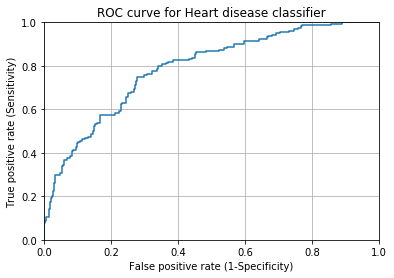

In [18]:
# Plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Heart disease classifier')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)

**Area Under The Curve (AUC)**

The area under the ROC curve quantifies model classification accuracy; higher the area, greater the disparity between true and false positives and stronger the model in classifying members of the training dataset. 

An area of 0.5 corresponds to a model that performs no better than random classification and a good classifier stays as close 1 as possible.

In [19]:
# Find area under curve
from sklearn.metrics import roc_auc_score
round(roc_auc_score(y_test,y_pred_prob_yes[:,1]), 2)

0.79

# Summary

* People in the 40-60 age group are most affected with CHD
* Tobacco consumption, high low density lipoprotein cholestrol (ldl, commonly known as bad cholestrol), presence of CHD in family and obesity contribute to CHD
* Accuracy of the model is 73%
* Better accuracy can certainly be achieved with more data
* The area under the ROC curve is 0.79 which is satisfactory